# Sales and Operations Planning
Before we start with the modelling part, let us gain a first view of the data sets and do some sanity checks. 

**Contents**

- [Data Understanding](#Data-Understanding) 
    - [Time](#Time)
    - [Products](#Products) 
    - [Plants](#Plants) 
        - [Plant List](#Plant-List)
        - [Plant Capacity](#Plant-Capacity)
        - [Plant*Product Capacity](#Plant*Product-Capacity)
        - [Plant*Product Cost](#Plant*Product-Cost)
    - [Markets](#Markets) 
        - [Market-Region](#Market-Region)
        - [Initial Inventory](#Initial-Inventory)
        - [Transportation](#Transportation)
        - [Demand](#Demand) 
        - [Firm Sales](#Firm-Sales)
        - [Revenue](#Revenue)

#### Insert a project token

When you import this project from the IBM Cloud Pak for Data/watsonx Gallery, a token is automatically generated and inserted at the top of this notebook as a code cell such as the one below:

```python
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='YOUR_PROJECT_ID', project_access_token='YOUR_PROJECT_TOKEN')
pc = project.project_context
```

If you do not see the cell above, follow these steps to enable the notebook to access the data set from the project's resources:

* Click `More -> Insert project token` in the top-right menu section
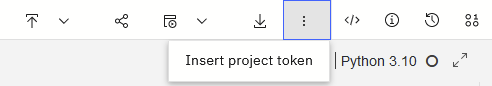

* This should insert a cell at the top of this notebook similar to the example given above.

  > If an error is displayed indicating that no project token is defined, follow [these instructions](https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/token.html?audience=wdp&context=data).

* Run the newly inserted cell before proceeding with the notebook execution below. It should look like the following cell:

In [2]:
#dd-ignore
# @hidden_cell
# from project_lib import Project
# project = Project(project_id='your-project-id', project_access_token='your-access-token')

## Data Understanding
As you could see from the following chart, the available data sets mainly describe three components, products, plants, and markets, as well as their characteristics, like the plant capacity, the market demand etc. The main purpose of this notebook is to load all the data sets, do some basic sanity checks to gain a first view of the data landscape and at the same time to verify the quality of the data, and see how the tables are linked to each other. 

As you can observed in the formulation section, the production planning as well as the sales forecasting take place on product, plant/market and month level, which means that the product type, region of the markets as well as the year & quarter only exist for further analysis as well as for descriptive purposes. Thus these tables are not described in detail here.

In [3]:
# from IPython.display import Image
# Image(url=project.get_file_url('Original_Datasets.png'), format='png', width=800, height=100) 

In [4]:
import pandas as pd
pd.set_option('display.max_columns', None)

from collections import namedtuple

In [5]:
from IPython.display import display, HTML
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

### Time

In [6]:
month = pd.read_csv(project.get_file('Months.csv'))
month.head(3)

id    name quarter
0   1  Jan-07  2007Q1
1   2  Feb-07  2007Q1
2   3  Mar-07  2007Q1

### Products

In [7]:
product_type = pd.read_csv(project.get_file('ProductTypes.csv'))
product = pd.read_csv(project.get_file('Products.csv'))
display_side_by_side([product_type.head(3), product.head(3)], ["product type", "product"])

Sanity check: are there duplicates for product name?
And how many products are there?

In [8]:
print("Duplicate Rows based on name are:", product[product.duplicated(['name'])], sep='\n')
print("Number of products: {n}".format(n=product.shape[0]))

Duplicate Rows based on name are:
Empty DataFrame
Columns: [name, type, maturity, priceLevel]
Index: []
Number of products: 29


Distribution of products across the four types

In [9]:
stats = pd.pivot_table(product, values='name', index=["type"], aggfunc="count")
stats

name
type          
Cruiser      6
Off-Road     7
Street      10
Touring      6

### Plants

#### Plant List

`Plants.csv` is a list all plants. 

In [10]:
plant = pd.read_csv(project.get_file('Plants.csv'))
plant.head(3)

name
0  Bucarest
1    Dallas
2   Houston

In [11]:
print("Number of plants: {n}".format(n=plant.shape[0]))

Number of plants: 7


#### Plant Capacity

`PlantMonthCapacities_flat.csv` tells us the total capacity of every plant on a monthly basis, regardless of the product or product type. 

In [12]:
plant_month_capacity = pd.read_csv(project.get_file('PlantMonthCapacities.csv'))
plant_month_capacity.head(3)

plant   month  value
0  Bucarest  Jul-08   3018
1  Bucarest  Aug-08   2688
2  Bucarest  Sep-08   3042

Again, let us first check whether there are duplicates, but this time for the plant + month combination. 

In [13]:
print("Duplicate Rows based on plant and month are:", plant_month_capacity[plant_month_capacity.duplicated(['plant','month'])], sep='\n')

Duplicate Rows based on plant and month are:
Empty DataFrame
Columns: [plant, month, value]
Index: []


Now let us confirm the opposite: is there a capacity limit for every single month and every plant?

In [14]:
stats = pd.pivot_table(plant_month_capacity, values='value', index=["plant"], columns="month", aggfunc="count")
stats

month        Apr-07  Apr-08  Aug-07  Aug-08  Dec-07  Dec-08  Feb-07  Feb-08  \
plant                                                                         
Bucarest          1       1       1       1       1       1       1       1   
Dallas            1       1       1       1       1       1       1       1   
Houston           1       1       1       1       1       1       1       1   
Los Angeles       1       1       1       1       1       1       1       1   
Mexico            1       1       1       1       1       1       1       1   
Shanghai          1       1       1       1       1       1       1       1   
Toledo            1       1       1       1       1       1       1       1   

month        Jan-07  Jan-08  Jul-07  Jul-08  Jun-07  Jun-08  Mar-07  Mar-08  \
plant                                                                         
Bucarest          1       1       1       1       1       1       1       1   
Dallas            1       1       1       1       1       1       1       1   
Houston           1       1       1       1       1       1       1       1   
Los Angeles       1       1       1       1       1       1       1       1   
Mexico            1       1       1       1       1       1       1       1   
Shanghai          1       1       1       1       1       1       1       1   
Toledo            1       1       1       1       1       1       1       1   

month        May-07  May-08  Nov-07  Nov-08  Oct-07  Oct-08  Sep-07  Sep-08  
plant                                                                        
Bucarest          1       1       1       1       1       1       1       1  
Dallas            1       1       1       1       1       1       1       1  
Houston           1       1       1       1       1       1       1       1  
Los Angeles       1       1       1       1       1       1       1       1  
Mexico            1       1       1       1       1       1       1       1  
Shanghai          1       1       1       1       1       1       1       1  
Toledo            1       1       1       1       1       1       1       1

#### Plant*Product Capacity

`PlantProductCapacities_flat.csv` specifies the capacity for the plants on product level, compared to `PlantMonthCapacities_flat.csv`. The month is not given in this data set, so we assume the capacity does not change over the months. Again, the formulation covers the case where the capacity varies across months, which is why we are going to add the time axis. 

In [15]:
plant_product_month_capacity = pd.read_csv(project.get_file('PlantProductMonthCapacities.csv'))
plant_product_month_capacity.head(3)

plant product   month  value
0  Bucarest    200S  Apr-07    210
1  Bucarest    200S  Apr-08    210
2  Bucarest    200S  Aug-07    210

Since one capacity is for the whole plant, whereas the other specifically for a product, then the product level capacity should always lie below the plant level one. 

In [16]:
# only pick the product with the highest capacity
df_compare = plant_product_month_capacity.groupby(['plant', 'month']).max()
df_compare.reset_index(inplace=True)
# drop the column product
df_compare.drop(['product'], axis=1, inplace=True)
# add the total capacity column
df_compare = df_compare.merge(plant_month_capacity, on = ["plant", "month"], how = "inner")
# see whether there is any product, which does not follow the rule. 
df_compare[df_compare["value_x"]>df_compare["value_y"]]

Empty DataFrame
Columns: [plant, month, value_x, value_y]
Index: []

#### Plant*Product Cost

`PlantProductCosts_flat.csv` lists the cost for producing one product in a specific plant.

In [17]:
plant_product_cost = pd.read_csv(project.get_file('PlantProductCosts.csv'))
plant_product_cost.head(3)

plant product  value
0  Bucarest  CRX600  240.5
1  Bucarest  CRX650  248.0
2  Bucarest  CRX500  233.0

As we already know, there are 29 products and 7 plants. So if every product could be produced in any plant, then there are 203 combinations. 

In [18]:
print("Number of plant + product combi: {n}".format(n=plant_product_cost.shape[0]))

Number of plant + product combi: 203


So in this specific case, a product could be produced in any plant. However, our formulation also applies for the general case, where a product could only be produced in some plant(s).

### Markets

#### Market-Region

The mapping of market to region is presented in `Markets_flat.csv`.

In [19]:
market = pd.read_csv(project.get_file('Markets.csv'))
region = pd.read_csv(project.get_file('Regions.csv'))
display_side_by_side([market.head(3), region.head(3)], ["Market", "Region"])

#### Initial Inventory

As the name says, `InitialInventories_flat.csv` shows us the initial inventory for every product in every market.

In [20]:
initial_inventory = pd.read_csv(project.get_file('InitialInventories.csv'))
initial_inventory.head(3)

product     market  value
0  Enduro 550  Argentina     19
1  Enduro 550         UK     17
2  Enduro 550     France     13

All of the markets in this data set should appear in `MarketsFlatTable.csv`. 

In [21]:
set(initial_inventory .market.unique().tolist()) - set(market.name.tolist())

set()

#### Transportation
Apart from production cost, the other main source of cost is the tranportation cost, which in our case is on plant-market-product level. 

In [22]:
transportation_cost = pd.read_csv(project.get_file('Transportation.csv'))
transportation_cost.head(3)

plant    name    region    product  value
0  Bucarest  Brazil  Americas     CRX650    114
1  Bucarest  Brazil  Americas  RoadLiner     74
2  Bucarest  Brazil  Americas       200S     49

#### Demand
Limited by its geography, economy, population etc., a market could only consume certain amount of products. Here we call this upper limit demand of a product in a market. This value could be found in `Demands_flat.csv`, which is presented on a monthly basis.

In [23]:
demand = pd.read_csv(project.get_file('Demands.csv'))
demand.head(3)

product market   month  value
0  Bandit 900  Spain  Jun-08     62
1  Bandit 900  Spain  Jul-08     55
2  Bandit 900  Spain  Aug-08     56

#### Firm Sales
Firm sales refer to planned orders that can be frozen in quantity and time, which is INCLUDED in the market demand.  

In [24]:
firm_sales = pd.read_csv(project.get_file('FirmSales.csv'))
firm_sales.head(3)

product  market   month  value
0  Bandit 1200S  Canada  Mar-07      1
1  Bandit 1200S  Brazil  Jan-07     12
2  Bandit 1200S  Brazil  Feb-07      4

#### Revenue

As mentioned above, the goal of this exercise is to maximize the total profit. The following table, `MarginalProfits_flat.csv` shows us sales price for every product on month-market level. 

In [25]:
sales_price = pd.read_csv(project.get_file('SalesPrice.csv'))
sales_price.head(3)

product market   month  value
0  Bandit 900  Spain  Nov-07    664
1  Bandit 900  Spain  Dec-07    639
2  Bandit 900  Spain  Jan-08    661

### Authors
-  __Qiannan Gao__ is a Data Scientist of the IBM Data Science & AI Elite Team.
-  __Eray Cakici__ is an Operations Research Scientist of the IBM Data Science & AI Elite Team.

### License
Copyright © 2020-2024 IBM. This notebook and its source code are released under the terms of the MIT License.